In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [22]:
def classify():
    #implement a general classifier pipeline which can be used for multiple sklearn classifiers
    return "not implemented"

def get_pr_score(y_test, y_pred, plot=True):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred) #area under PR curve
    
    if plot:
        plt.clf()
        plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')
        plt.show()
    
    return avg_precision

def get_roc_score(y_test, y_pred, plot=True):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) #area under PR curve
    
    if plot:
        plt.clf()
        plt.plot(fpr, tpr, lw=2, color='navy', label='Precision-Recall curve')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.show()
    
    return roc_auc

In [13]:
if __name__ == "__main__":
    training_rows = range(50000)
    data = pd.read_csv("/home/kaushalya/Coding/wsdm_cup/vandalism/data/features100k_preprocessed_new.csv",
                       encoding='utf-8', header=0)
    labeled_data_file = "/home/kaushalya/Coding/wsdm_cup/vandalism/data/wikidata-vandalism-corpus-2015/wdvc15-ground-truth.csv"
    labeled_data = pd.read_csv(labeled_data_file, header=0)

In [16]:
    x_train = data.ix[training_rows,1:]
    y_train = labeled_data.ix[training_rows,'rollback_reverted']
    #TODO grid search to set parameters of the model
    clf = RandomForestClassifier(n_estimators=100, max_depth=8)
    clf.fit(x_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [17]:
    in_test = ~data.index.isin(training_rows)
    x_test = data.ix[in_test,1:]
    y_test = labeled_data.ix[in_test,'rollback_reverted']

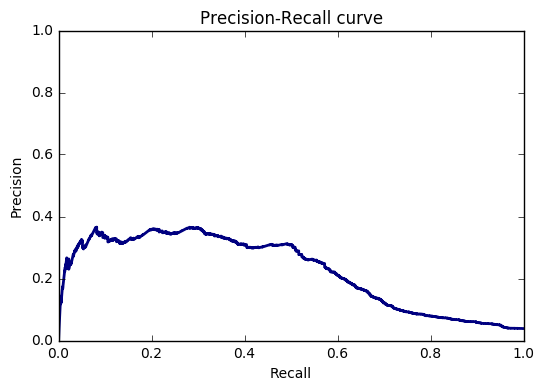

area under PR curve:0.224336
logloss score: 0.063111


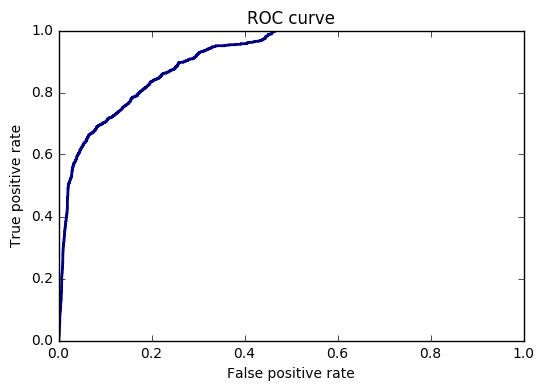

ROC-AUC score: 0.913569


In [23]:
    y_pred = clf.predict_proba(x_test)
    logloss_score = log_loss(y_test, y_pred)

    print("area under PR curve:%f"%get_pr_score(y_test, y_pred[:,1]))
    print("logloss score: %f"%logloss_score)
    print("ROC-AUC score: %f"%get_roc_score(y_test, y_pred[:,1]))